<a href="https://colab.research.google.com/github/Dayche5/prosent/blob/product_classification/product_classification-resnet-efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import zipfile
import gdown
import numpy as np
import pandas as pd

PRODUCT_CLASSIFICATION_TRAIN_URL = "https://drive.google.com/u/0/uc?id=1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq&export=download"
PRODUCT_CLASSIFICATION_TEST_URL = "https://drive.google.com/u/0/uc?id=1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6&export=download"
SENTIMENT_ANAYLSIS_TRAIN_URL = "https://drive.google.com/u/0/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&export=download"
SENTIMENT_ANAYLSIS_TEST_URL = "https://drive.google.com/u/0/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB&export=download"
SENTIMENT_ANALYSIS_TITLE_BRAND_URL = "https://drive.google.com/u/0/uc?id=1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h&export=download"

PRODUCT_CLASSIFICATION_DATA_PATH = "data/product_classification"
SENTIMENT_ANALYSIS_DATA_PATH = "data/sentiment_analysis"

def fetch_data(url, path, output):
    """
    Download data from url to path
    Unzip them if required
    """
    if not os.path.exists(path):
        os.makedirs(path)

    file_path = os.path.join(path, output)

    # check if data already exists
    if os.path.exists(file_path) or os.path.exists(file_path.replace('.zip', '')):
        return

    # download data
    gdown.download(url, file_path, quiet=False)

    # unzip data
    if output.endswith(".zip"):
        with zipfile.ZipFile(file_path) as zip_ref:
            zip_ref.extractall(path)
            original_name = zip_ref.namelist()[0]
            zip_ref.close()

        # remove zip file
        os.remove(file_path)
        os.rename(os.path.join(path, original_name), file_path.replace('.zip', ''))

def fetch_product_classification_data():
    """
    Fetch product classification data
    return: path to where data is stored
    """
    fetch_data(PRODUCT_CLASSIFICATION_TRAIN_URL, PRODUCT_CLASSIFICATION_DATA_PATH, "train.zip")
    fetch_data(
        PRODUCT_CLASSIFICATION_TEST_URL,
        os.path.join(PRODUCT_CLASSIFICATION_DATA_PATH, 'test'), "nonlabels.zip")

    return PRODUCT_CLASSIFICATION_DATA_PATH

def fetch_sentiment_analysis_data():
    """
    Fetch sentiment analysis data
    return: path to where data is stored
    """
    fetch_data(SENTIMENT_ANAYLSIS_TRAIN_URL, SENTIMENT_ANALYSIS_DATA_PATH, "train_data.csv")
    fetch_data(SENTIMENT_ANAYLSIS_TEST_URL, SENTIMENT_ANALYSIS_DATA_PATH, "test_data.csv")
    fetch_data(SENTIMENT_ANALYSIS_TITLE_BRAND_URL, SENTIMENT_ANALYSIS_DATA_PATH, "title_brand.csv")

    return SENTIMENT_ANALYSIS_DATA_PATH

def fetch_all_data():
    """
    Fetch all data
    """
    fetch_product_classification_data()
    fetch_sentiment_analysis_data()

def load_sentiment_analysis_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load sentiment analysis data

    return: train_data, test_data, title_brand_data as pandas dataframe
    """
    fetch_sentiment_analysis_data()
    train_data_path = os.path.join(SENTIMENT_ANALYSIS_DATA_PATH, "train.csv")
    test_data_path = os.path.join(SENTIMENT_ANALYSIS_DATA_PATH, "test.csv")
    title_brand_data_path = os.path.join(SENTIMENT_ANALYSIS_DATA_PATH, "title_brand.csv")

    # Load data
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
    title_brand_data = pd.read_csv(title_brand_data_path)

    return train_data, test_data, title_brand_data


def load_product_classification_data():
    return fetch_product_classification_data()

if __name__ == "__main__":
    fetch_all_data()

Downloading...
From: https://drive.google.com/u/0/uc?id=1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq&export=download
To: /content/data/product_classification/train.zip
100%|██████████| 173M/173M [00:00<00:00, 323MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6&export=download
To: /content/data/product_classification/test/nonlabels.zip
100%|██████████| 73.0M/73.0M [00:00<00:00, 220MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&export=download
To: /content/data/sentiment_analysis/train_data.csv
100%|██████████| 635M/635M [00:03<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB&export=download
To: /content/data/sentiment_analysis/test_data.csv
100%|██████████| 15.6M/15.6M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h&export=download
To: /content/data/sentiment_analysis/title_brand.csv

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from dataclasses import dataclass
from tensorflow import keras
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [4]:
SEED_VALUE = 42

In [5]:
# Download data and get a path to where it's downloaded
PATH_DATA = fetch_product_classification_data()
PATH_TRAIN = os.path.join(PATH_DATA, 'train')
PATH_TEST = os.path.join(PATH_DATA, 'test')

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
  NUM_CLASSES: int = 10
  IMG_HEIGHT:  int = 224
  IMG_WIDTH:   int = 224
  CHANNELS:    int = 3
  PATH_TRAIN:  str = os.path.join(PATH_DATA, 'train')
  PATH_TEST:   str = os.path.join(PATH_DATA, 'train')

@dataclass
class TrainingConfig:
  batch_size:       int = 16
  epochs:           int = 7
  learning_rate:    float = 1e-3
  dropout_rate:     float = 0.5
  layers_fine_tune: int = 2


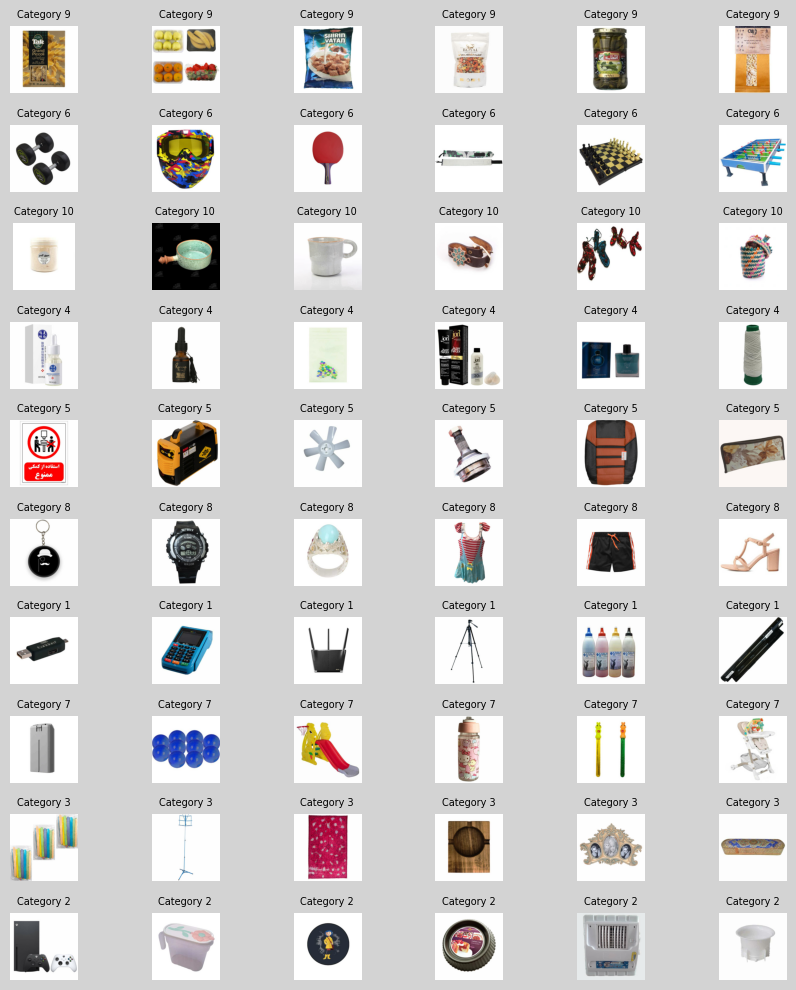

In [7]:
# Let's show some samples from dataset
ns = 6 # number of samples for each class
nc = 10 # number of classes
fig, axes = plt.subplots(nc, ns, figsize=(ns * 1.5, nc))
np.random.seed(SEED_VALUE)

for i, dir in enumerate(os.listdir(PATH_TRAIN)):
  path_dir = os.path.join(PATH_TRAIN, dir)
  file_names = os.listdir(os.path.join(PATH_TRAIN, dir))
  file_names_selected = np.random.choice(file_names, ns, replace=False)
  for j, _ in enumerate(file_names_selected):
    name_file = file_names_selected[j]
    path_file = os.path.join(path_dir, name_file)
    image_file = tf.io.read_file(path_file)
    image = tf.image.decode_image(image_file, channels=3)
    axes[i, j].imshow(image / 255)
    axes[i, j].axis('off')
    title = axes[i, j].set_title(f'Category {dir}')
    title.set_fontsize(7)

fig.set_facecolor('lightgray')
plt.tight_layout()
plt.show()

In [13]:
### Test a ResNet101V2 based model on dataset ####

# Specify training config for resnet based model
train_config_ResNet101V2 = TrainingConfig(
    batch_size=64, epochs=12, learning_rate=0.0001,
    layers_fine_tune=4)

# Specify the model input shape
input_shape = (
    DatasetConfig.IMG_HEIGHT,
    DatasetConfig.IMG_WIDTH,
    DatasetConfig.CHANNELS
)

# Load the ResNet101V2 model (only conv layers) with pre-trained weights
ResNet101V2_conv_base = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Specify the number of layers to fine tune at the end of the convolutional base
num_layers_fine_tune = train_config_ResNet101V2.layers_fine_tune
num_layers = len(ResNet101V2_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in ResNet101V2_conv_base.layers[:num_layers - num_layers_fine_tune]:
  model_layer.trainable = False

# Add custom layer top of resnet base
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = ResNet101V2_conv_base(x)
x = GlobalAveragePooling2D()(x)

x = layers.Dense(
    1024, activation='relu',
    kernel_initializer='random_normal',
    kernel_regularizer=L2(0.04))(x)

#x = layers.Dropout(train_config_ResNet101V2.dropout_rate)(x)

outputs = layers.Dense(
    DatasetConfig.NUM_CLASSES,
    kernel_initializer='random_normal',
    activation='softmax')(x)

# The final model.
model_ResNet101V2_finetune = keras.Model(inputs, outputs)

print(model_ResNet101V2_finetune.summary())

# Compile the model
model_ResNet101V2_finetune.compile(
    optimizer=Adam(learning_rate=train_config_ResNet101V2.learning_rate),
    loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing and augmentation
datagen = ImageDataGenerator(
  #  rescale=1./1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create data generators
train_generator = datagen.flow_from_directory(
    PATH_TRAIN,
    target_size=input_shape[:2],
    batch_size=train_config_ResNet101V2.batch_size,
    class_mode='categorical',
    subset='training',
)

validation_generator = datagen.flow_from_directory(
    PATH_TRAIN,
    target_size=input_shape[:2],
    batch_size=train_config_ResNet101V2.batch_size,
    class_mode='categorical',
    subset='validation',
)

# Add an arlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=2, restore_best_weights=True)



171317808/171317808 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                

In [14]:
# Train the model
history = model_ResNet101V2_finetune.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=train_config_ResNet101V2.epochs,
    callbacks=[early_stopping],
)

Epoch 1/12
125/125 [==============================] - 160s 1s/step - loss: 180.7025 - accuracy: 0.3760 - val_loss: 151.4088 - val_accuracy: 0.4604
Epoch 2/12
125/125 [==============================] - 144s 1s/step - loss: 128.1250 - accuracy: 0.5443 - val_loss: 107.2594 - val_accuracy: 0.5195
Epoch 3/12
125/125 [==============================] - 150s 1s/step - loss: 90.6138 - accuracy: 0.6088 - val_loss: 75.8978 - val_accuracy: 0.5346
Epoch 4/12
125/125 [==============================] - 148s 1s/step - loss: 64.0068 - accuracy: 0.6376 - val_loss: 53.6878 - val_accuracy: 0.5636
Epoch 5/12
125/125 [==============================] - 146s 1s/step - loss: 45.1922 - accuracy: 0.6650 - val_loss: 38.0239 - val_accuracy: 0.5691
Epoch 6/12
125/125 [==============================] - 146s 1s/step - loss: 31.9363 - accuracy: 0.6824 - val_loss: 26.9672 - val_accuracy: 0.5731
Epoch 7/12
125/125 [==============================] - 145s 1s/step - loss: 22.6124 - accuracy: 0.6905 - val_loss: 19.2637 - va

In [18]:
model_ResNet101V2_finetune.save('/content/drive/MyDrive/Colab Notebooks/Models/Resnet.keras')

In [11]:
### Test a EfficientNetB7 based model on dataset ####

# Specify training config for resnet based model
train_config_EfficientNetB7  = TrainingConfig(
    batch_size=64, epochs=12, learning_rate=0.0001,
    layers_fine_tune=4)

# Specify the model input shape
input_shape = (
    DatasetConfig.IMG_HEIGHT,
    DatasetConfig.IMG_WIDTH,
    DatasetConfig.CHANNELS
)

# Load the ResNet101V2 model (only conv layers) with pre-trained weights
EfficientNetB7_conv_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Specify the number of layers to fine tune at the end of the convolutional base
num_layers_fine_tune = train_config_EfficientNetB7.layers_fine_tune
num_layers = len(EfficientNetB7_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in EfficientNetB7_conv_base.layers[:num_layers - num_layers_fine_tune]:
  model_layer.trainable = False

# Add custom layer top of resnet base
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = EfficientNetB7_conv_base(x)
x = GlobalAveragePooling2D()(x)

x = layers.Dense(
    1024, activation='relu',
    kernel_initializer='random_normal',
    kernel_regularizer=L2(0.04))(x)

#x = layers.Dropout(train_config_EfficientNetB7.dropout_rate)(x)

outputs = layers.Dense(
    DatasetConfig.NUM_CLASSES,
    kernel_initializer='random_normal',
    activation='softmax')(x)

# The final model.
model_EfficientNetB7_finetune = keras.Model(inputs, outputs)

print(model_EfficientNetB7_finetune.summary())

# Compile the model
model_EfficientNetB7_finetune.compile(
    optimizer=Adam(learning_rate=train_config_EfficientNetB7.learning_rate),
    loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing and augmentation
datagen = ImageDataGenerator(
  #  rescale=1./1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create data generators
train_generator = datagen.flow_from_directory(
    PATH_TRAIN,
    target_size=input_shape[:2],
    batch_size=train_config_EfficientNetB7.batch_size,
    class_mode='categorical',
    subset='training',
)

validation_generator = datagen.flow_from_directory(
    PATH_TRAIN,
    target_size=input_shape[:2],
    batch_size=train_config_EfficientNetB7.batch_size,
    class_mode='categorical',
    subset='validation',
)

# Add an arlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=2, restore_best_weights=True)



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              2622464   
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 66730401 (254.56 MB)
Trainable params: 427623

In [12]:
# Train the model
history = model_EfficientNetB7_finetune.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=train_config_EfficientNetB7.epochs,
    callbacks=[early_stopping],
)

Epoch 1/12
125/125 [==============================] - 207s 1s/step - loss: 220.2203 - accuracy: 0.3943 - val_loss: 180.3655 - val_accuracy: 0.5135
Epoch 2/12
125/125 [==============================] - 175s 1s/step - loss: 150.2879 - accuracy: 0.5494 - val_loss: 123.5499 - val_accuracy: 0.5486
Epoch 3/12
125/125 [==============================] - 177s 1s/step - loss: 103.1372 - accuracy: 0.5894 - val_loss: 85.0066 - val_accuracy: 0.5646
Epoch 4/12
125/125 [==============================] - 176s 1s/step - loss: 71.0471 - accuracy: 0.6152 - val_loss: 58.6862 - val_accuracy: 0.5666
Epoch 5/12
125/125 [==============================] - 176s 1s/step - loss: 49.0554 - accuracy: 0.6293 - val_loss: 40.6248 - val_accuracy: 0.5676
Epoch 6/12
125/125 [==============================] - 177s 1s/step - loss: 33.9757 - accuracy: 0.6357 - val_loss: 28.2099 - val_accuracy: 0.5797
Epoch 7/12
125/125 [==============================] - 176s 1s/step - loss: 23.5983 - accuracy: 0.6420 - val_loss: 19.7017 - v